In [1]:
import sys
import os
import subprocess
import pandas as pd
import numpy as np
import tempfile
import yaml

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

import os

from datetime import date
print(date.today())
# conda install mkl-service mkl
import mkl
nCPU= 20
N=4


2025-11-27


In [2]:
# 准备结果目录和流程所需config文件
# level 1
workdir = '/mnt/disk7t/xwj/axolotl_rev/'
title = 'pmuscle_36'

if title == 'pmuscle_36':
    output_path = f'{workdir}/result/dataset_pmuscle_36'
    datasetdir = f'{workdir}/pmuscle_36_processed' 
    use = 'pmuscle36' # 13k gene min 10 reads
    # use = 'pmuscle36_0'
    tissues = pd.read_csv(f'{datasetdir}/tissues_{use}.tsv', sep='\t', index_col=0)
    phase =''
    outlier_sample_col = 'Sample'
    outlier_gene_col = 'Gene' 
else:
    pass
# level 2
samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'
print(samples_path)
tissues.head()

/mnt/disk7t/xwj/axolotl_rev//result/dataset_pmuscle_36/samples


,TISSUE_ID,TISSUE_NAME,N_SAMPLE,N_GENE,CTS_FILE,OUTLIER_FILE
0,M,muscle,36,13573,/mnt/disk7t/xwj/axolotl_rev/pmuscle_36_process...,/mnt/disk7t/xwj/axolotl_rev/pmuscle_36_process...


In [3]:
## topn recall

def pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier):
    """
    计算ABEILLE方法单个打分方式的AUPRC
    参数:
        res_data: 包含预测结果的DataFrame
        score_col: 用于排序的打分列名
        df_outlier: 包含真实异常的DataFrame
    """
    # 按predict和score排序
    ascend = score_order[ score_col ]
    sorted_data = res_data.pivot_table(columns=sample_col, index=gene_col, values=score_col).rank(ascending=ascend, method='first')
    outlier_rank = [ sorted_data.loc[g,s] for g,s in zip(df_outlier['Gene'], df_outlier['Sample'])]
    new_df_outlier = df_outlier.copy() # must make a copy
    new_df_outlier['rank'] = outlier_rank
    return new_df_outlier

def sort_score_outlier_rank(res_data, df_outlier, ascend=True):
    sorted_data = res_data.rank(ascending=ascend, method='first')
    outlier_rank = [ sorted_data.loc[g,s] for g,s in zip(df_outlier['Gene'], df_outlier['Sample'])]
    new_df_outlier = df_outlier.copy() # must make a copy
    new_df_outlier['rank'] = outlier_rank
    return new_df_outlier


In [5]:
# methods = [ 'OUTRIDER', 'OUTSINGLE', 'MyMethod']
baselines = [ 'OUTRIDER', 'OUTSINGLE', 'ABEILLE' ]
abl_scores = ['anomaly_score', 'delta_count', 'divergence_score']
outrider_scores = [ 'pValue', 'zScore','padjust']
outrider_scores = [ 'padjust']
baselines = [ f'{m}_{score}' for m in ['OUTRIDER', 'ABEILLE'] for score in (outrider_scores if m=='OUTRIDER' else abl_scores) ] + ['OUTSINGLE']

mymethods = [ f'f{i}{md}' for i in list(range(20,24)) for md in ['L','I','O']] 
mymethods = [ f'{f}{m}' for f in ['f0', 'f0.05','f0.1','f0.2', 'f0.5','f1', 'f2','f4'] 
             for m in ['L10', 'L20','L30', 'L40'] ]
# mymethods = [ f'{f}{m}' for f in ['f0', 'f0.05','f0.1','f0.2', 'f0.5','f1', 'f2','f4'] for m in [ 'L30', ] ]
mymethods = [ f'{f}{m}' for f in ['f0.1', ] 
             for m in ['L20',] ]
methods = baselines + mymethods
# methods = ['OUTSINGLE', ] + mymethods

num = 49
print(num, phase, methods)

49  ['OUTRIDER_padjust', 'ABEILLE_anomaly_score', 'ABEILLE_delta_count', 'ABEILLE_divergence_score', 'OUTSINGLE', 'f0.1L20']


In [6]:
methods = ['OUTRIDER_padjust',
 'ABEILLE_anomaly_score',
 'ABEILLE_delta_count',
 'ABEILLE_divergence_score',
 'OUTSINGLE',
 'f0.1L20',
]
# methods = ['OUTRIDER',
#  'ABEILLE',
#  'OUTSINGLE',
#  'f0.1L20',
# ]

from tqdm import tqdm
# 为兼容以后的子集抽样，需要定义保存不同抽样方案的outlier
dict_outlier_setting = dict()
dict_outlier_setting['all'] = {} 

# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True,
}

gene_sizes = [ 12000 ]
n_replicates = 10  # 每个样本量重复10次
random_seeds = range(n_replicates)  # 使用0-9作为随机种子

for i, row in tissues.iterrows():
    # --> level 1. one tissue
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    # 创建基础前缀
    name_prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    
    # positive samples
    outlier = pd.read_csv(outlierfile, sep='\t', index_col=0)
    assert outlier['Sample'].size == len(set(outlier['Sample']))
    # SS
    output_file = f'{task_config_path}/{name_prefix}_sampled_configs_dict.pkl'
    # name_prefix = 't00_FBSS_s269_g12369'
    # NS
    # output_file = f'{task_config_path}/t01_FBNS_s154_g13411_sampled_configs_dict.pkl'
    # name_prefix = 't01_FBNS_s154_g13411'
    import pickle
    sampled_configs = pickle.load(open(output_file, 'rb'))
    outliers_used = outlier.copy()
    
    
    for size in gene_sizes:
        print(size)

        dict_res = dict()
        dict_auprc = dict()
        dict_curve = dict()
        for seed in range(n_replicates):
            k = seed
            dict_res[k] = dict() # 10 seeds 
            dict_auprc[k] = dict()
            dict_curve[k] = dict()
            # 获取当前抽样的配置
            current_config = sampled_configs[f'size_{size}'][f'seed_{seed}']
            task_config = current_config['config']
            samples_used = current_config['selected_samples']
            df_outlier = outliers_used.query('(Sample in @samples_used)').copy()
            
            for m in methods:
                # ==> level 3. (tissue, task, method)
                print(size, seed, m)
                dict_res[k][m]= dict()
                dict_curve[k][m] = dict()
                for j,row in task_config.iterrows():
                    if m.startswith('ABEILLE'):
                        method, score_col = m.split('_',1)
                        res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                        res_data.index = [(s,g) for s,g in zip(res_data['Sample'], res_data['Transcript'])]
                        class_col = 'predict'
                        gene_col = 'Transcript'
                        sample_col = 'Sample'
                        dict_curve[k][m][j] = pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier)
                                
                    elif m.startswith('OUTRIDER'):
                        method, score_col = m.split('_',1)
                        res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                        res_data.index = [(s,g) for s,g in zip(res_data['sampleID'], res_data['geneID'])]
                        class_col = 'aberrant'
                        gene_col = 'geneID'
                        sample_col = 'sampleID'
                        dict_curve[k][m][j] = pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier)
                    
                    elif m == 'OUTSINGLE':
                        df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                        dict_curve[k][m][j] = sort_score_outlier_rank(df_pred, df_outlier)  
                                                  
                    else: # my method
                        df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                        dict_curve[k][m][j] = sort_score_outlier_rank(df_pred, df_outlier)
                                                        
        file = f'{metric_output_path}/{name_prefix}_size_{size}_rank{phase}.pkl'
        outputdata = [ t, tn, i, dict_curve ]
        import pickle
        with open(file, 'wb') as f: 
            pickle.dump( outputdata,  f )


12000
12000 0 OUTRIDER_padjust
12000 0 ABEILLE_anomaly_score
12000 0 ABEILLE_delta_count
12000 0 ABEILLE_divergence_score
12000 0 OUTSINGLE
12000 0 f0.1L20
12000 1 OUTRIDER_padjust
12000 1 ABEILLE_anomaly_score
12000 1 ABEILLE_delta_count
12000 1 ABEILLE_divergence_score
12000 1 OUTSINGLE
12000 1 f0.1L20
12000 2 OUTRIDER_padjust
12000 2 ABEILLE_anomaly_score
12000 2 ABEILLE_delta_count
12000 2 ABEILLE_divergence_score
12000 2 OUTSINGLE
12000 2 f0.1L20
12000 3 OUTRIDER_padjust
12000 3 ABEILLE_anomaly_score
12000 3 ABEILLE_delta_count
12000 3 ABEILLE_divergence_score
12000 3 OUTSINGLE
12000 3 f0.1L20
12000 4 OUTRIDER_padjust
12000 4 ABEILLE_anomaly_score
12000 4 ABEILLE_delta_count
12000 4 ABEILLE_divergence_score
12000 4 OUTSINGLE
12000 4 f0.1L20
12000 5 OUTRIDER_padjust
12000 5 ABEILLE_anomaly_score
12000 5 ABEILLE_delta_count
12000 5 ABEILLE_divergence_score
12000 5 OUTSINGLE
12000 5 f0.1L20
12000 6 OUTRIDER_padjust
12000 6 ABEILLE_anomaly_score
12000 6 ABEILLE_delta_count
12000 6 ABE

t00_M_s36_g13573


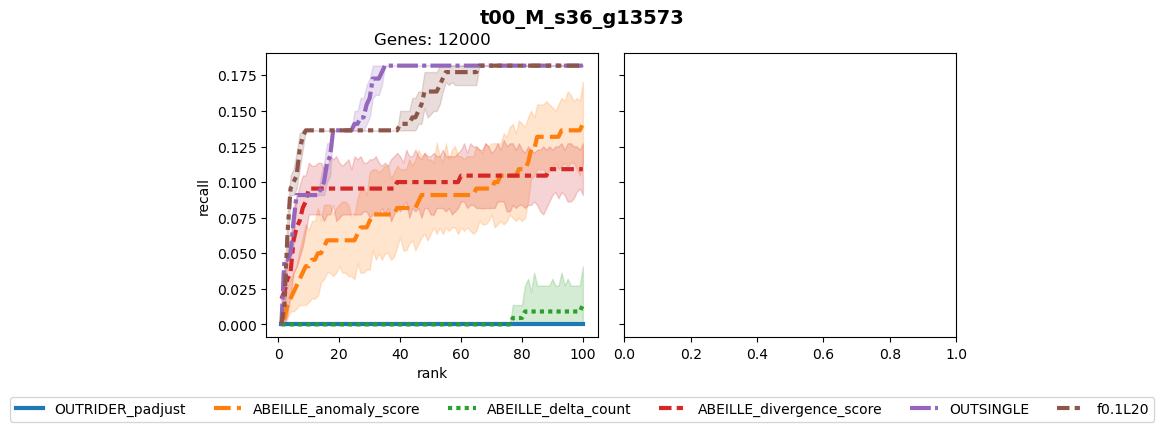

In [21]:
draw_methods = methods

# 从tissues中获取信息
for i, tissue_data in tissues.iterrows():
    # tissue_data = tissues.iloc[0]
    t = tissue_data['TISSUE_ID']  # TISSUE_ID
    tn = tissue_data['TISSUE_NAME']  # TISSUE_NAME
    ns = tissue_data['N_SAMPLE']  # N_SAMPLE
    ng = tissue_data['N_GENE']  # N_GENE

    # 创建基础前缀
    name_prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    print(name_prefix)

    plt.style.use('default')

    fig, axes = plt.subplots(1, len(gene_sizes)+1, figsize=(8*len(gene_sizes), 4), sharey=True )
    myindex = pd.MultiIndex.from_tuples([ (size, k) for size in gene_sizes for k in range(n_replicates) ],names=['size', 'seed'])
    auprc =  pd.DataFrame(index= myindex, columns=draw_methods, dtype=np.float32)

    for i, size in enumerate(gene_sizes):
         # file = f'{metric_output_path}/t{i:02d}_{t}_auprc.pkl'
        file = f'{metric_output_path}/{name_prefix}_size_{size}_rank{phase}.pkl'
        with open(file,'rb') as f:
            data_load = pickle.load(f)
        _t, _tn, _i, dict_curve = data_load[0], data_load[1], data_load[2], data_load[3]
            
        required_sets = 1
        max_bin = 100
        bins = list(range(0, max_bin + 1)) + [20000]
        nice_names = list(range(1,max_bin + 1))+[20000]#[ f'{x}%' for x in bins[:-1]]

        draw = \
        pd.concat([
        pd.concat( [ 
            pd.concat( [ (dict_curve[k][m][j]['rank']).value_counts(bins = bins, sort=False) for j in range(required_sets)],
                    axis=0, keys= range(required_sets))
            for m in draw_methods ], axis=0, keys=draw_methods, names=['method'])
        for k in range(n_replicates)], axis = 0, keys=range(n_replicates),names=['rep']).reset_index()
        draw['rank'] = nice_names * len(draw_methods) * n_replicates
        draw = draw.query('rank < 10000').copy()
        draw['recall'] = draw.groupby(['method','rep'])['count'].cumsum()/len(df_outlier)

        sns.lineplot(
            data=draw,
            x="rank",
            y="recall",
            hue="method",
            palette='tab10',
            ax=axes[i],
            errorbar=('ci', 95),  # 90%置信区间
            n_boot=100,  # bootstrap采样次数
            alpha=1,
            linewidth=3,
            style='method',
        )
        axes[i].set_title(f'Genes: {size}')
            # 1. 去掉子图自己的图例
        axes[i].get_legend().remove()

    # 2. 用最后一根轴的“handles/labels”生成 Figure 级图例
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels,
            loc='center',           # 居中
            bbox_to_anchor=(0.5, 0.02),  # 放在底部（微调 0.02）
            ncol=len(labels),       # 横向排列
            frameon=True)

    plt.tight_layout()
    # 给图例留一点底部空间
    fig.subplots_adjust(bottom=0.2)
    fig.suptitle(name_prefix, y=1.02, fontsize=14, fontweight='bold')
    # 保存，用于画 boxplot